The packages and the dataset used 

In [19]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import os
from torchaudio.datasets import SPEECHCOMMANDS

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

import librosa
import numpy as np

dataset = SPEECHCOMMANDS(root=os.getcwd(),download=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Preprocess the audio files. The target_file is the wake word to be detected. 3/4 of this file is used for training and 1/4 is used for testing.

The negative examples in the training/testing files is randomly sampled from other audio clips. The negative examples and positive examples have the same size in the training/testing set

In [20]:


dataset_path = "SpeechCommands/speech_commands_v0.02"

target_file = "four"

train_set = []
test_set = []

negative_files = [f for f in os.listdir(dataset_path) if not os.path.isfile(os.path.join(dataset_path, f)) and f!='_background_noise_' and f!=target_file]

print(len(train_set))

target_file_path = dataset_path +"/"+target_file

total_size = len(os.listdir(target_file_path))

count = 0

for file_path in os.listdir(target_file_path):
    file_name = target_file_path+"/" + file_path
    audio, sample_rate = torchaudio.load(file_name)
    if count < total_size*0.75:
        train_set.append([audio,sample_rate,file_name,1]) ## wake word
    else:
        test_set.append([audio,sample_rate,file_name,1])
    count +=1


## sampling other wake words as negative examples
for _ in range(len(train_set)*2):
    folder = dataset_path+"/"+np.random.choice(negative_files)
    file =folder+ "/"+ np.random.choice(os.listdir(folder))
    audio, sample_rate = torchaudio.load(file)
    train_set.append([audio,sample_rate,file,0])

for _ in range(len(test_set)*3):
    folder = dataset_path+"/"+np.random.choice(negative_files)
    file =folder+ "/"+ np.random.choice(os.listdir(folder))
    audio, sample_rate = torchaudio.load(file)
    test_set.append([audio,sample_rate,file,0])




0


An example of the audio clip

In [21]:

index = np.random.randint(len(train_set))
print(f"index:{index}")
print(train_set[index])
print(train_set[index][0].shape)

display(ipd.Audio(train_set[index][0].numpy(), rate=train_set[index][1]))

print(len(test_set))

index:4281
[tensor([[ 0.0014,  0.0036,  0.0058,  ..., -0.0007,  0.0009,  0.0019]]), 16000, 'SpeechCommands/speech_commands_v0.02/down/234ab0fb_nohash_1.wav', 0]
torch.Size([1, 16000])


3728


Example of the mfcc feature. Librosa and torchaudio both can generate mfcc features but the result is slitly different. In the following code librosa is used as a demostration but torchaudio is used for training 

[tensor([[-0.0016, -0.0072, -0.0082,  ...,  0.0036,  0.0050, -0.0013]]), 16000, 'SpeechCommands/speech_commands_v0.02/cat/5be23def_nohash_0.wav', 0]


Shape of mfcc: (40, 32)


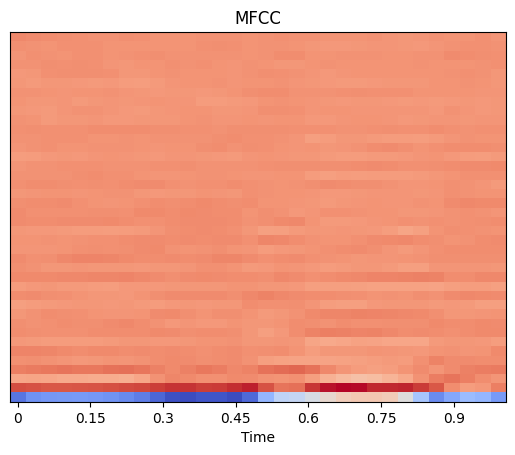

In [22]:
index = np.random.randint(len(train_set))
print(train_set[index])
sampling_rate = train_set[index][1]

display(ipd.Audio(train_set[index][0].numpy(), rate=sampling_rate))

# transform = torchaudio.transforms.MFCC(sample_rate=16000)
# # mfcc = transform(train_set[index][0])
# # mfcc = transform(aaa.squeeze())
# xxx = train_set[index][0][0].numpy()
# print(f"xxx: {train_set[index][0][0].numpy()}")

mfcc = librosa.feature.mfcc(y=train_set[index][0][0].numpy(), sr=sampling_rate,n_mfcc=40)

# print(mfcc)

print("Shape of mfcc:", mfcc.shape)
plt.title("MFCC")
# librosa.display.specshow(mfcc.numpy()[0], sr=16000, x_axis='time')
librosa.display.specshow(mfcc, sr=16000, x_axis='time')
plt.show()
# print(mfcc)
# print(mfcc.shape)
# print(type(mfcc))

Deep learning model. The input is transposed to get the correct size then 

In [23]:
class myLSTM(nn.Module):

    def __init__(self, mfcc_size, hidden_dim, output_size):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.normLayer = nn.LayerNorm(mfcc_size)
        
        self.lstm = nn.LSTM(mfcc_size, hidden_dim,batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.activation =  nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_dim,output_size)
        self.sig  = nn.Sigmoid()

    def forward(self, mfcc):
        mfcc = mfcc.transpose(1,2) ## change from 40*81 to 81*40
        mfcc = self.normLayer(mfcc)
        lstm_out, (hidden_last,cell_last)= self.lstm(mfcc) ## batch size* number of mfcc * mfcc feature size
        output = self.linear2(self.activation(self.linear(hidden_last)))
        output = self.sig(output)
        # print(f"output shape:{output.shape}")
        # output = F.softmax(output, dim=2)
        return output
    
model = myLSTM(mfcc_size=40,hidden_dim=40,output_size=1)
model.to(device)

myLSTM(
  (normLayer): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(40, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=40, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=40, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [24]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.001)
    transform = torchaudio.transforms.MFCC(sample_rate=16000)
    mfcc = transform(batch)
    return mfcc

def collate_fn(batch):

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, sample_rate, file_path ,label in batch:
        
        tensors += [waveform.squeeze()] ## 1x40x81 to 40x81
        targets += [torch.tensor(label).float()]
        # print(tensors)
        # print(targets)

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [25]:

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [26]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # loss = F.nll_loss(output.squeeze(), target)
        # loss = nn.BCEWithLogitsLoss()(output.squeeze(0,2), target)
        loss = F.cross_entropy(output.squeeze(0,2), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")


In [27]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    acc = rounded_preds.eq(y.view_as(rounded_preds)).sum().item() / len(y)
    return acc


from sklearn.metrics import classification_report

def test(test_loader, model, device, epoch):
    print("\n starting test for epoch %s"%epoch)
    accs = []
    preds = []
    labels = []
    with torch.no_grad():
        for idx, (mfcc, label) in enumerate(test_loader):
            mfcc, label = mfcc.to(device), label.to(device)
            output = model(mfcc)
            # pred = torch.sigmoid(output)
            acc = binary_accuracy(output, label)
            preds += torch.flatten(torch.round(output)).cpu()
            labels += torch.flatten(label).cpu()
            accs.append(acc)
            print("Iter: {}/{}, accuracy: {}".format(idx, len(test_loader), acc), end="\r")
    average_acc = sum(accs)/len(accs) 
    print('Average test Accuracy:', average_acc, "\n")
    report = classification_report(labels, preds)
    print(report)
    return average_acc, report

In [32]:
log_interval = 20
n_epoch = 20

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(test_loader, model, device,epoch)


Train Epoch: 1 [0/8388 (0%)]	Loss: 460.603851
Train Epoch: 1 [5120/8388 (61%)]	Loss: 458.542938

 starting test for epoch 1
Average test Accuracy: 0.9348958333333334 

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      2796
         1.0       0.84      0.92      0.88       932

    accuracy                           0.93      3728
   macro avg       0.90      0.93      0.92      3728
weighted avg       0.94      0.93      0.94      3728

Train Epoch: 2 [0/8388 (0%)]	Loss: 478.086853


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 2 [5120/8388 (61%)]	Loss: 452.107819

 starting test for epoch 2
Average test Accuracy: 0.9294270833333333 

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      2796
         1.0       0.81      0.93      0.87       932

    accuracy                           0.93      3728
   macro avg       0.89      0.93      0.91      3728
weighted avg       0.93      0.93      0.93      3728

Train Epoch: 3 [0/8388 (0%)]	Loss: 445.850098


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 3 [5120/8388 (61%)]	Loss: 448.035919

 starting test for epoch 3
Average test Accuracy: 0.93125 75

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      2796
         1.0       0.85      0.88      0.86       932

    accuracy                           0.93      3728
   macro avg       0.90      0.91      0.91      3728
weighted avg       0.93      0.93      0.93      3728

Train Epoch: 4 [0/8388 (0%)]	Loss: 413.626709


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 4 [5120/8388 (61%)]	Loss: 390.509277

 starting test for epoch 4
Average test Accuracy: 0.8979166666666667 

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      2796
         1.0       0.73      0.95      0.82       932

    accuracy                           0.90      3728
   macro avg       0.85      0.92      0.88      3728
weighted avg       0.92      0.90      0.90      3728

Train Epoch: 5 [0/8388 (0%)]	Loss: 497.167145


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 5 [5120/8388 (61%)]	Loss: 485.626526

 starting test for epoch 5
Average test Accuracy: 0.9148726851851853 

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94      2796
         1.0       0.76      0.96      0.85       932

    accuracy                           0.92      3728
   macro avg       0.87      0.93      0.90      3728
weighted avg       0.93      0.92      0.92      3728

Train Epoch: 6 [0/8388 (0%)]	Loss: 458.612854


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 6 [5120/8388 (61%)]	Loss: 397.766479

 starting test for epoch 6
Average test Accuracy: 0.9213252314814814 

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95      2796
         1.0       0.78      0.95      0.86       932

    accuracy                           0.92      3728
   macro avg       0.88      0.93      0.90      3728
weighted avg       0.93      0.92      0.92      3728

Train Epoch: 7 [0/8388 (0%)]	Loss: 410.114319


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 7 [5120/8388 (61%)]	Loss: 364.193756

 starting test for epoch 7
Average test Accuracy: 0.9078125 

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      2796
         1.0       0.75      0.96      0.84       932

    accuracy                           0.91      3728
   macro avg       0.87      0.93      0.89      3728
weighted avg       0.93      0.91      0.91      3728

Train Epoch: 8 [0/8388 (0%)]	Loss: 458.615723


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 8 [5120/8388 (61%)]	Loss: 358.481018

 starting test for epoch 8
Average test Accuracy: 0.9402488425925927 

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      2796
         1.0       0.86      0.91      0.88       932

    accuracy                           0.94      3728
   macro avg       0.91      0.93      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 9 [0/8388 (0%)]	Loss: 419.399109


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 9 [5120/8388 (61%)]	Loss: 376.494263

 starting test for epoch 9
Average test Accuracy: 0.9377025462962963 

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      2796
         1.0       0.85      0.91      0.88       932

    accuracy                           0.94      3728
   macro avg       0.91      0.93      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 10 [0/8388 (0%)]	Loss: 462.729614


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 10 [5120/8388 (61%)]	Loss: 430.172577

 starting test for epoch 10
Average test Accuracy: 0.9260127314814814 

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      2796
         1.0       0.79      0.95      0.87       932

    accuracy                           0.93      3728
   macro avg       0.89      0.94      0.91      3728
weighted avg       0.94      0.93      0.93      3728

Train Epoch: 11 [0/8388 (0%)]	Loss: 455.358215


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 11 [5120/8388 (61%)]	Loss: 490.071777

 starting test for epoch 11
Average test Accuracy: 0.9313657407407407 

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      2796
         1.0       0.81      0.95      0.87       932

    accuracy                           0.93      3728
   macro avg       0.90      0.94      0.91      3728
weighted avg       0.94      0.93      0.93      3728

Train Epoch: 12 [0/8388 (0%)]	Loss: 333.266235


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 12 [5120/8388 (61%)]	Loss: 488.646271

 starting test for epoch 12
Average test Accuracy: 0.9181134259259259 

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      2796
         1.0       0.78      0.95      0.85       932

    accuracy                           0.92      3728
   macro avg       0.88      0.93      0.90      3728
weighted avg       0.93      0.92      0.92      3728

Train Epoch: 13 [0/8388 (0%)]	Loss: 427.551422


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 13 [5120/8388 (61%)]	Loss: 431.360809

 starting test for epoch 13
Average test Accuracy: 0.9367766203703703 

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      2796
         1.0       0.83      0.93      0.88       932

    accuracy                           0.94      3728
   macro avg       0.91      0.94      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 14 [0/8388 (0%)]	Loss: 408.238403


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 14 [5120/8388 (61%)]	Loss: 414.224304

 starting test for epoch 14
Average test Accuracy: 0.927662037037037 

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      2796
         1.0       0.80      0.94      0.87       932

    accuracy                           0.93      3728
   macro avg       0.89      0.93      0.91      3728
weighted avg       0.93      0.93      0.93      3728

Train Epoch: 15 [0/8388 (0%)]	Loss: 443.691803


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 15 [5120/8388 (61%)]	Loss: 388.880920

 starting test for epoch 15
Average test Accuracy: 0.9371238425925926 

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      2796
         1.0       0.83      0.94      0.88       932

    accuracy                           0.94      3728
   macro avg       0.90      0.94      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 16 [0/8388 (0%)]	Loss: 438.186218


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 16 [5120/8388 (61%)]	Loss: 392.107971

 starting test for epoch 16
Average test Accuracy: 0.940769675925926 

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2796
         1.0       0.87      0.89      0.88       932

    accuracy                           0.94      3728
   macro avg       0.92      0.92      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 17 [0/8388 (0%)]	Loss: 442.016357


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 17 [5120/8388 (61%)]	Loss: 479.420532

 starting test for epoch 17
Average test Accuracy: 0.9282407407407407 

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      2796
         1.0       0.80      0.95      0.87       932

    accuracy                           0.93      3728
   macro avg       0.89      0.93      0.91      3728
weighted avg       0.94      0.93      0.93      3728

Train Epoch: 18 [0/8388 (0%)]	Loss: 421.346558


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 18 [5120/8388 (61%)]	Loss: 491.150177

 starting test for epoch 18
Average test Accuracy: 0.9280960648148148 

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95      2796
         1.0       0.80      0.96      0.87       932

    accuracy                           0.93      3728
   macro avg       0.89      0.94      0.91      3728
weighted avg       0.94      0.93      0.93      3728

Train Epoch: 19 [0/8388 (0%)]	Loss: 335.220093


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 19 [5120/8388 (61%)]	Loss: 362.496643

 starting test for epoch 19
Average test Accuracy: 0.9380787037037037 

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      2796
         1.0       0.83      0.94      0.88       932

    accuracy                           0.94      3728
   macro avg       0.91      0.94      0.92      3728
weighted avg       0.94      0.94      0.94      3728

Train Epoch: 20 [0/8388 (0%)]	Loss: 444.872986


/home/tao/miniconda3/envs/nlp/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Train Epoch: 20 [5120/8388 (61%)]	Loss: 471.666443

 starting test for epoch 20
Average test Accuracy: 0.9338252314814814 

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96      2796
         1.0       0.82      0.95      0.88       932

    accuracy                           0.93      3728
   macro avg       0.90      0.94      0.92      3728
weighted avg       0.94      0.93      0.94      3728



In [29]:
torch.save(model.state_dict(), target_file+".pt")

In [43]:
index = np.random.randint(len(test_set))
print(f"index:{index}")
print(test_set[index])

display(ipd.Audio(test_set[index][0].numpy(), rate=16000))
audio = test_set[index][0]
transform = torchaudio.transforms.MFCC(sample_rate=16000)
mfcc = transform(audio).to(device)
# print(mfcc)
prediction = model(mfcc)
print(prediction)

index:297
[tensor([[ 0.0000e+00,  0.0000e+00,  3.0518e-05,  ..., -8.2397e-04,
         -7.3242e-04, -5.4932e-04]]), 16000, 'SpeechCommands/speech_commands_v0.02/four/fc3ba625_nohash_2.wav', 1]


tensor([[[1.]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [50]:
######## IMPORTS ##########
import sounddevice as sd
from scipy.io.wavfile import write
import librosa
import numpy as np

####### ALL CONSTANTS #####
fs = 16000
seconds = 3
filename = "prediction.wav"
isLoad = True

##### LOADING OUR SAVED MODEL and PREDICTING ###

if isLoad:
    target_file = "right"
    model = myLSTM(mfcc_size=40,hidden_dim=40,output_size=1).to(device)
    model.load_state_dict(torch.load("save_file/"+target_file +".pt"))

print("Prediction Started: ")
while True:
    # print("Say Now: ")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()
    # print(f"myrecording:{myrecording}")
    write(filename, fs, myrecording)

    audio, sample_rate = torchaudio.load(filename)

    # print(f"hello:{audio[:,0:int(fs/2)].shape}")
    
    if seconds>1:
        clips = [audio[0,0:fs]]
        for i in range(seconds-1):
            clips.append(audio[0,i*fs:(i+1)*fs])
            clips.append(audio[0,int(fs/2)+i*fs:int(fs/2)+(i+1)*fs])

        clips = torch.stack(clips)
    else:
        clips = audio
    # print(clips.shape)

    transform = torchaudio.transforms.MFCC(sample_rate=16000)
    mfcc = transform(clips).to(device)

    model.eval()
    
    prediction = model(mfcc)
    prediction = prediction.squeeze().to("cpu").detach().numpy()

    # print(prediction)

    if seconds==1:
        if prediction> 0.99:
            print(f"Wake Word Detected for {target_file }")
            print(prediction)
        else:
            print(f"No word")
            print(prediction)
    elif seconds>1:    
        if max(prediction)> 0.99:
            print(f"Wake Word Detected for {target_file }")
            print(prediction)
        else:
            print(f"No word")
            print(prediction)
    


Prediction Started: 
No word
[0.00025439 0.00025439 0.00041174 0.00075849 0.00033746]
Wake Word Detected for right
[2.1430357e-04 2.1430357e-04 6.7817559e-03 9.7183575e-04 9.9999797e-01]
No word
[8.1513419e-05 8.1513419e-05 9.6441996e-05 2.2772333e-06 1.9243821e-04]
No word
[1.6666565e-04 1.6666565e-04 2.3620742e-04 7.3080892e-03 5.5238633e-07]
No word
[2.1376641e-06 2.1376641e-06 7.4164086e-07 2.1686824e-04 1.4964522e-04]
No word
[0.00020354 0.00020354 0.00025892 0.00023637 0.00044177]
Wake Word Detected for right
[4.5610536e-03 4.5610536e-03 9.9887806e-01 1.7991816e-04 8.6879671e-05]
No word
[0.00037504 0.00037504 0.00024617 0.00026569 0.00030908]
No word
[1.4559923e-07 1.4559923e-07 6.2024543e-07 5.0189368e-07 3.6990525e-07]
No word
[5.0438780e-07 5.0438780e-07 3.7396481e-07 1.5232556e-04 6.1547449e-05]
No word
[3.9530590e-07 3.9530590e-07 7.3736473e-06 2.8479322e-05 8.6156200e-05]
Wake Word Detected for right
[1.02835045e-04 1.02835045e-04 6.78618562e-06 9.99908209e-01
 1.37678013e

KeyboardInterrupt: 